<a href="https://colab.research.google.com/github/Draconov/hwhrec/blob/main/TransferLearning_Hebrew_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✨ Transfer Learning for Handwritten Hebrew Letters
This notebook uses **Transfer Learning** with pretrained CNN models to classify handwritten Hebrew letters.

**Models Used:**
- VGG16
- MobileNetV2

**Steps:**
1. Preprocess dataset
2. Build models
3. Train with frozen and unfrozen base
4. Evaluate performance

# 📦 1. Imports and Setup

In [ ]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# 🧼 2. Preprocessing Function

In [ ]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None
    h, w = img.shape
    if h > w:
        pad = (h - w) // 2
        img = cv2.copyMakeBorder(img, 0, 0, pad, h - w - pad, cv2.BORDER_CONSTANT, value=255)
    elif w > h:
        pad = (w - h) // 2
        img = cv2.copyMakeBorder(img, pad, w - h - pad, 0, 0, cv2.BORDER_CONSTANT, value=255)
    img = cv2.resize(img, (96, 96))
    img = 255 - img
    img = img.astype(np.float32) / 255.0
    return np.stack([img]*3, axis=-1)

# 📥 3. Dataset Loader

In [ ]:
from google.colab import files
files.upload()  # Upload hhd.zip

import zipfile

os.makedirs("hhd_dataset", exist_ok=True)

with zipfile.ZipFile("hhd.zip", 'r') as zip_ref:
    zip_ref.extractall("hhd_dataset")

def load_dataset(base_dir):
    X, y = load_dataset("hhd_dataset")
    for label in range(27):
        folder = os.path.join(base_dir, str(label))
        if not os.path.exists(folder): continue
        for fname in os.listdir(folder):
            img_path = os.path.join(folder, fname)
            img = preprocess_image(img_path)
            if img is not None:
                X.append(img.reshape(32, 32, 1))
                y.append(label)
    return np.array(X), np.array(y)

Saving hhd.zip to hhd.zip


# 🔀 4. Load and Split Dataset

In [ ]:
import shutil
from sklearn.model_selection import train_test_split

image_paths = []
labels = []

# Collect image paths and labels
for label in range(27):
    class_dir = os.path.join("hhd_dataset", str(label))
    if not os.path.exists(class_dir):
        continue
    for fname in os.listdir(class_dir):
        if fname.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(label)

# Split
X_temp, X_test, y_temp, y_test = train_test_split(image_paths, labels, test_size=0.1, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42)

# Define save function
def save_split(X, y, folder):
    for path, label in zip(X, y):
        out_dir = os.path.join("processed_hhd", folder, str(label))
        os.makedirs(out_dir, exist_ok=True)
        shutil.copy(path, os.path.join(out_dir, os.path.basename(path)))

# Save to folders
save_split(X_train, y_train, "train")
save_split(X_val, y_val, "val")
save_split(X_test, y_test, "test")

# Define load dataset function
def load_dataset(base_dir):
    X, y = [], []
    for label in range(27):
        folder = os.path.join(base_dir, str(label))
        if not os.path.exists(folder):
            continue
        for fname in os.listdir(folder):
            img_path = os.path.join(folder, fname)
            img = preprocess_image(img_path)
            if img is not None:
                X.append(img)
                y.append(label)
    return np.array(X), np.array(y)

# Load images for CNN
X_train, y_train = load_dataset("processed_hhd/train")
X_val, y_val     = load_dataset("processed_hhd/val")
X_test, y_test   = load_dataset("processed_hhd/test")

# 📚 5. Applying pretrained model

In [ ]:
def build_transfer_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(27, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

In [ ]:
def train_model(base_model, name):
    base_model.trainable = False
    model = build_transfer_model(base_model)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

    # Unfreeze and fine-tune
    base_model.trainable = True
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)
    model.save(f'{name}.h5')
    return model, history

In [ ]:
model_vgg, hist_vgg = train_model(VGG16(include_top=False, weights='imagenet', input_shape=(96,96,3)), 'vgg16_hhd')
model_mob, hist_mob = train_model(MobileNetV2(include_top=False, weights='imagenet', input_shape=(96,96,3)), 'mobilenetv2_hhd')

Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.0873 - loss: 3.2973 - val_accuracy: 0.4901 - val_loss: 2.3519
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.3094 - loss: 2.3787 - val_accuracy: 0.6245 - val_loss: 1.5572
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4618 - loss: 1.8174 - val_accuracy: 0.6660 - val_loss: 1.2404
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5305 - loss: 1.6230 - val_accuracy: 0.7431 - val_loss: 1.0532
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5681 - loss: 1.4596 - val_accuracy: 0.7431 - val_loss: 0.9993
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5947 - loss: 1.3056 - val_accuracy: 0.7470 - val_loss: 0.9328
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6150 - loss: 1.2407 - val_accuracy: 0.7767 - val_loss: 0.8778
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6149 - loss: 1.2237 - val_a

Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.2046 - loss: 3.1196 - val_accuracy: 0.6621 - val_loss: 1.2261
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5442 - loss: 1.4842 - val_accuracy: 0.7095 - val_loss: 0.9661
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6332 - loss: 1.1921 - val_accuracy: 0.7273 - val_loss: 0.8858
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6709 - loss: 1.0595 - val_accuracy: 0.7213 - val_loss: 0.8431
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6849 - loss: 0.9832 - val_accuracy: 0.7431 - val_loss: 0.8185
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7057 - loss: 0.9173 - val_accuracy: 0.7569 - val_loss: 0.7952
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7136 - loss: 0.8876 - val_accuracy: 0.7648 - val_loss: 0.7948
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7121 - loss: 0.8267 - val_ac

In [ ]:
def evaluate_model(model, name):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=2, output_dict=True)
    accs = [report[str(i)]['precision'] if str(i) in report else 0 for i in range(27)]
    avg = np.mean(accs)
    with open(f'results_{name}.txt', 'w') as f:
        for i, acc in enumerate(accs): f.write(f'Letter {i}: {acc:.2f}\n')
        f.write(f'Average accuracy: {avg:.4f}\n')
    pd.DataFrame(cm).to_csv(f'confusion_matrix_{name}.csv', index=False)
    print(f"{name} Average Accuracy: {avg:.4f}")

In [ ]:
evaluate_model(model_vgg, 'vgg16')
evaluate_model(model_mob, 'mobilenetv2')

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
vgg16 Average Accuracy: 0.9180
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step
mobilenetv2 Average Accuracy: 0.5732


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 6. 📊 Plot Training & Validation Accuracy and Loss

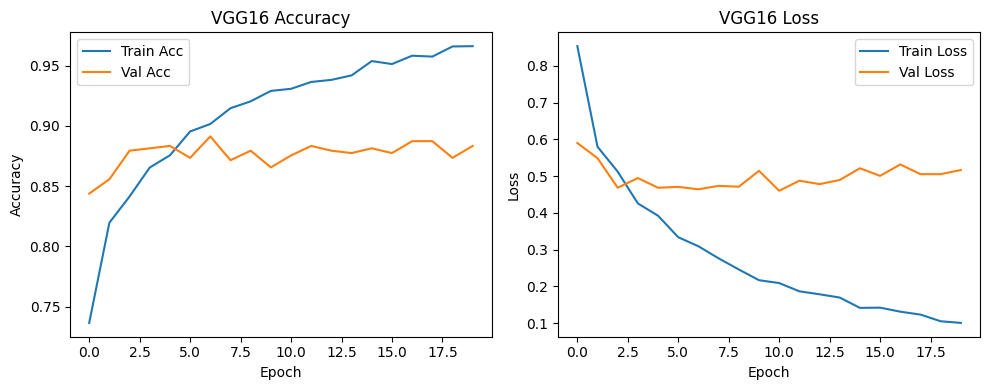

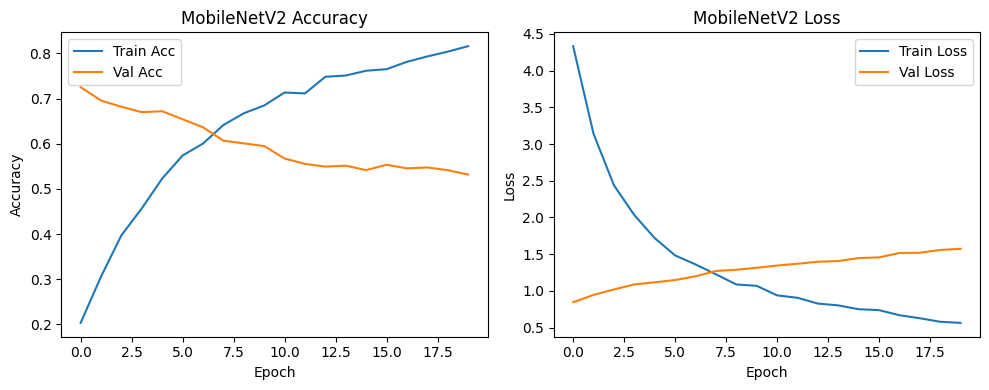

In [ ]:
def plot_history(history, title):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}_plots.png')
    plt.show()

plot_history(hist_vgg, "VGG16")
plot_history(hist_mob, "MobileNetV2")